<a href="https://colab.research.google.com/github/AdrianKopperud/automatedfeatureengineering/blob/main/Baseline_Master_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U pandas-profiling
#!pip install bayesian-optimization

### Import functions

In [ ]:
# Import
from sklearn import preprocessing
import pandas as pd
import numpy as np
import gc
import re
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_rows', 3000)

In [ ]:


# Function to calculate Precision and Recall

def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and test_y[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')


def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = xgb.XGBClassifier(num_boost_round=100, n_estimators = 240, tree_method='gpu_hist', )
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df


def check_missing(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : 'Num', 1 : 'Rate'})
    return col

def plot_missing_pct(df, features, feature_name):
    '''this function draw bar plot of missing value percentage '''
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    
    ax.bar(features, df[features].isnull().mean())
    ax.set_ylim(0,1)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('% missing data')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    plt.title('Percentage of missing values of {}'.format(feature_name))
    plt.show()

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(24,24))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

## Function to reduce the DF size
def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
def conf_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

### 1 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Data
id = pd.read_csv("/content/drive/MyDrive/Thesis/Data/ID.csv")
tran = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Transaction.csv")

# Remove vesta features V_xxxx
tran = tran.loc[:,~tran.columns.str.startswith('V')]

# Merge the classes 
df = pd.merge(tran, id, how="outer", on=["TransactionID"])

del tran
del id

### 2 Pre-processing

Create categories for each e-mail provider and cluster e-mail within the company provider. As such we could reduce the number of categories from 60 to a few. __Furthermore did I split up the .com, .us and so on into suffix, not sure if that may be future engineering since the data in the categorical variable are split into two different new variables.__

#### 2.1 Catagorical features

##### 2.1.1 P_emaildomain and R_emaildomain

In [ ]:
# fill naemail features: P_emaildomain, R_emaildomain
# email features: P_emaildomain, R_emaildomain
# email map
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# fill na
df.loc[:, ['P_emaildomain', 'R_emaildomain']] = df[['P_emaildomain', 'R_emaildomain']].fillna('None')

# clean email domains
df = df.assign(P_emaildomain_bin = df['P_emaildomain'].map(emails),
          P_emaildomain_suffix = df['P_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
          R_emaildomain_bin = df['R_emaildomain'].map(emails),
          R_emaildomain_suffix = df['R_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
        )

df.loc[:, ['P_emaildomain_bin', 'R_emaildomain_bin']] = df[['P_emaildomain_bin', 'R_emaildomain_bin']].fillna('None')


df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

##### 2.1.2 Device features, DeviceInfo and DeviceType

For DeviceType, DeviceInfo and other id_xx variables with device info regarding screen size, phone producer and browser, did I cluster the different brands of same name into one brand. This reduces the number of categories. Furthermore, was the NAN observations filled with None. 

In [ ]:
# deveice features: DeviceInfo, DeviceType
# device map
devices = {'SM': 'Samsung', 'SAMSUNG': 'Samsung', 'GT-': 'Samsung', 'Moto G': 'Motorola',
           'Moto': 'Motorola', 'moto': 'Motorola', 'LG-': 'LG', 'VS\d{3}': 'LG', 'LG\w{2}\d{3}': 'LG', 'rv': 'RV', 'HUAWEI': 'Huawei',
           'ALE-':'Huawei', '-L':'Huawei', 'hi6210sft': 'Huawei', 'CHC-U03': 'Huawei', 'Blade': 'ZTE', 'Z\d{3}': 'ZTE', 'BLADE': 'ZTE', 'ZTE':'ZTE', 
           'Linux': 'Linux', 'XT': 'Sony', 'F\d{4}': 'Sony', 'E\d{4}': 'Sony', 'G\d{4}': 'Sony', 'HTC': 'HTC', 'ASUS': 'Asus',
           'Pixel': 'Pixel', 'Lenovo': 'Lenovo', 'Windows': 'Windows', 'Redmi': 'Redmi', 'Ilium': 'Ilium', 'ILIUM': 'Ilium',
           'Hisense': 'Hisense', 'KF': 'Amazon', 'Android': 'Android', '\d{4}A': 'Alcatel', '\d{4}W': 'Alcatel', '\d{4}M': 'Alcatel', 
           'Alcatel': 'Alcatel', 'ALCATEL':'Alcatel', '\d{4}G': 'Mozilla', 'M4': 'M4', 'TA-': 'Nokia', 'NOKIA': 'Nokia', 'Nexus':'Nexus', 'BLU':'BLU'}

# devices_list = df.loc[:,'device_name'].value_counts().where(lambda x : x>80).dropna().index.values

devices_list = ['None', 'Windows', 'iOS Device', 'MacOS', 'Samsung', 'Trident', 'RV',
               'Motorola', 'LG', 'Huawei', 'Sony', 'ZTE', 'HTC', 'Alcatel', 'Lenovo',
               'Ilium', 'Pixel', 'Hisense', 'Amazon', 'Mozilla', 'M4', 'Redmi',
               'Nokia', 'Linux', 'Nexus', 'Android']

# clean device name
df.loc[:,'DeviceName'] = df['DeviceInfo'].str.split('/').str[0].fillna('None')
for k,v in devices.items():
    df.loc[df['DeviceName'].str.contains(k, na=False), 'DeviceName'] = v
df.loc[~df['DeviceName'].isin(devices_list), 'DeviceName'] = 'Others'

# remove DeviceInfo
df.drop(['DeviceInfo'], axis=1, inplace=True)

# DeviceType - fillna
df.loc[:,'DeviceType'] = df['DeviceType'].fillna('None')

##### 2.1.3 Other categorical features, address and card

Further I converted address and card variables from float to categorical/object as they were specified by VESTA in (https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) to be categorical. Hence, should not be treated as numerical values as they have another meaning. Further was NAN values filled with NONE to remove the missing values and use a common new category for all missing values to keep the pattern in the data. 

In [ ]:
# other categorical features (address, card, M features)
addr_features = df.columns[df.columns.str.contains('addr')].values.tolist()
card_features = df.columns[df.columns.str.contains('card')].values.tolist()
m_features = df.columns[df.columns.str.contains('M\d+')].values.tolist()

# int to float
features_to_int = df[addr_features+card_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, features_to_int] = df.loc[:, features_to_int].astype('Int64')

# int to str
df.loc[:, addr_features+card_features] = df.loc[:, addr_features+card_features].astype(str)

# fill na
df.loc[:, addr_features+card_features+m_features] = df[addr_features+card_features+m_features].fillna('None')

# clean card type
df['card6'] = df['card6'].map(lambda x: 'None' if x not in ['debit', 'credit', 'None'] else x)

##### 2.1.4 ID_features

Clean the categorical ID_xx variables that goes from ID_12 until ID_38 + "DeviceInfo" and "DeviceType". We convert the categorical ID_xx from float to object/category as the numbers in the variables which are categorical (specified by VESTA) do not have the same numeric meaning as true numeric float variables.__Furthermore, do we split the id_01 - id_11 into its own category which we will treat accordingly in the numerical cleaning part for id_xx features!__

In [ ]:
id_features = df.columns[df.columns.str.contains('id_\d+')]
cat_id_features = ['id_'+str(x).zfill(2) for x in range(12, 38+1)]
num_id_features = ['id_'+str(x).zfill(2) for x in range(1, 12)]

In [ ]:
# missing value check
num_check_df = pd.DataFrame({'Missing Percentage': np.round(df[num_id_features].isnull().mean()*100), 
              'Zero Percentage': np.round((df[num_id_features]==0).mean()*100),
              'Total Percentage': np.round((df[num_id_features].isnull()|(df[num_id_features]==0)).mean()*100)})\
            .sort_values('Total Percentage', ascending=False)
    
cat_check_df = pd.DataFrame({'Missing Percentage': np.round(df[cat_id_features].isnull().mean()*100),
                             'Nunique': df[cat_id_features].nunique()})\
            .sort_values('Missing Percentage', ascending=False)
    
# drop missing + zero values >= 99%
num_id_features_todrop = num_check_df[num_check_df['Total Percentage'] >= 99].index.values.tolist()
num_id_features_tokeep = num_check_df[num_check_df['Total Percentage'] < 99].index.values.tolist()
df.drop(num_id_features_todrop, axis=1, inplace=True)

cat_id_features_todrop = cat_check_df[cat_check_df['Missing Percentage'] >= 99].index.values.tolist()
cat_id_features_tokeep = cat_check_df[cat_check_df['Missing Percentage'] < 99].index.values.tolist()
df.drop(cat_id_features_todrop, axis=1, inplace=True)

In [ ]:
# int to float
cat_id_features_to_int = df[cat_id_features_tokeep].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype('Int64')

# int to str
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype(str)

# fill na with None
df[cat_id_features_tokeep] = df[cat_id_features_tokeep].fillna('None')

# id - system
df['sys_id_30'] = df['id_30'].str.split(' ').str[0]
sys_list = ['Windows', 'iOS', 'Mac', 'Android', 'Linux', 'None']
df['sys_id_30'] = np.where(df['sys_id_30'].isin(sys_list), df['sys_id_30'], 'None')

# id - browser
browsers = {'safari': 'safari', 'chrome': 'chrome', 'samsung': 'samsung', 'Samsung': 'samsung', 'edge': 'edge', 
 'firefox': 'firefox', 'ie':'ie', 'google':'google', 'other':'others', 'None':'None'}
browsers_list = ['chrome','safari','ie','firefox','edge','samsung','None']
for k,v in browsers.items():
    df.loc[df['id_31'].str.contains(k, na=False), 'browser_id_31'] = v
df.loc[~df['browser_id_31'].isin(browsers_list), 'browser_id_31'] = 'others'

# id - screen
df.loc[df['id_33']=='0x0', 'id_33'] = 'None'
screen_height = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[1].astype(int)
bins = [0, 900, 1500, np.inf]
screen_height_cate = pd.cut(screen_height, bins, labels=['s', 'm', 'l'])
screen_width = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[0].astype(int)
bins = [0, 1200, 2000, np.inf]
screen_width_cate = pd.cut(screen_width, bins, labels=['s', 'm', 'l'])

screen = screen_width_cate.astype(str) + 'x' + screen_height_cate.astype(str)
df.loc[df['id_33']!='None', 'screen_id_33'] = screen
df.loc[df['id_33']=='None', 'screen_id_33'] = 'None'

# drop id 30, 31, 33
df.drop(['id_30','id_31','id_33'], axis=1, inplace=True)
cat_id_features_tokeep.remove('id_30')
cat_id_features_tokeep.remove('id_31')
cat_id_features_tokeep.remove('id_33')

# Append categorical to list
cat_id_features_tokeep.extend(['sys_id_30', 'browser_id_31', 'screen_id_33'])

gc.collect()

20

##### 2.1.5 Label encoder

In [ ]:
# Label Encoding
category = []
for f in df.drop('isFraud', axis=1).columns:
    if df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        category.append(f)
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

#### 2.2 Numerical features

##### 2.2.1 Transaction features

AxesSubplot(0.125,0.125;0.775x0.755)


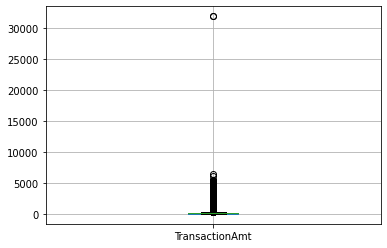

In [ ]:
# Vizualize outliers thorugh boxplot
print(df.boxplot('TransactionAmt'))

In [ ]:
df.drop(df.loc[df['TransactionAmt']>15000].index, inplace=True)

##### 2.2.2 dist features

In [ ]:
# Dist features
pd.DataFrame(np.round(df[['dist1', 'dist2']].isnull().mean()*100), columns = ['Missing Percentage'])

# drop dist 2
df.drop(['dist2'], axis=1, inplace=True)

##### 2.2.3 Remove TransactionID



In [ ]:
df.drop("TransactionID", axis=1, inplace=True)

##### 2.2.4 Impute numeric NAN

In [ ]:
df = df.fillna(-999)

#### 2.3 Split Train/Test & Validation





In [ ]:
# Isolate target variable
y = df.pop('isFraud')
X = df.copy(deep=True)

In [ ]:
# Test = 70%, Validation = 14%, Test = 16%
# Split is done by 3 different time sequences. 

train_length = 472432
test_length = 590540

train_X, train_y = X.iloc[:train_length], y.iloc[:train_length]
test_X, test_y = X.iloc[train_length:test_length], y.iloc[train_length:test_length]

train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

In [ ]:
# Reduce memory
memory_reducer(train_X)
memory_reducer(test_X)

Mem. usage decreased to 57.22 Mb (80.4% reduction)
Mem. usage decreased to 14.30 Mb (80.4% reduction)


### 3 Model


#### ** PICKEL **

In [ ]:
# CLEAN DATA FOR MODELING
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_train_baseline.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_test_baseline.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_train_baseline.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_test_baseline.pkl')

#### 3.1 Cross validation with AUC





##### XGBoost

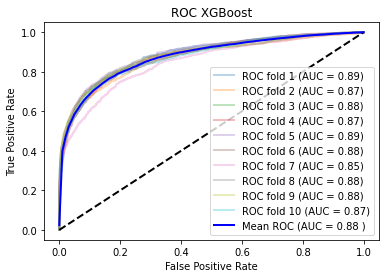

In [ ]:
#XGB
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

x = train_X.copy()
y = train_y.copy()

random_state = np.random.RandomState(0)
clf = XGBClassifier(tree_method='gpu_hist')
cv = TimeSeriesSplit(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend(loc="lower right")
plt.show()

##### Random Forest

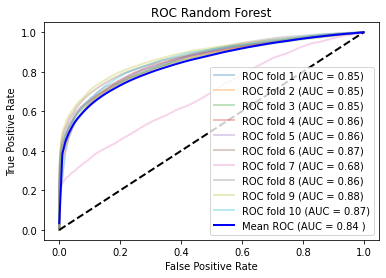

In [ ]:
#Random Forest
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

x = train_X.copy()
y = train_y.copy()

random_state = np.random.RandomState(0)
clf = RandomForestClassifier()
cv = TimeSeriesSplit(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend(loc="lower right")
plt.show()

##### Logistic Regression

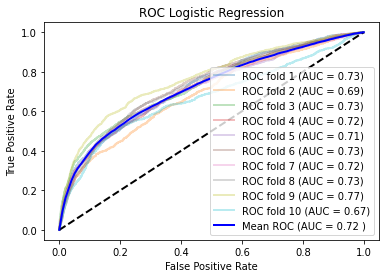

In [ ]:
#Logistic regression
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

x = train_X.copy()
y = train_y.copy()

random_state = np.random.RandomState(0)
clf = LogisticRegression(max_iter=10000)
cv = TimeSeriesSplit(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic Regression')
plt.legend(loc="lower right")
plt.show()

##### Naive Bayes

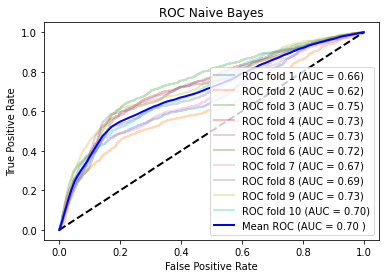

In [ ]:
# Naive Bayes
import matplotlib.pylab as plt
from scipy import interp
from sklearn.metrics import roc_curve,auc
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

x = train_X.copy()
y = train_y.copy()

random_state = np.random.RandomState(0)
clf = GaussianNB()
cv = TimeSeriesSplit(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Naive Bayes')
plt.legend(loc="lower right")
plt.show()

#### 3.2 XGB Bayesian Optimization Tuning

In [ ]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(train_X, label=train_y)
dtest = xgb.DMatrix(test_X)

In [ ]:
def xgb_evaluate(max_depth, n_estimators, learning_rate, min_child_weight, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate,
              'min_child_weight': min_child_weight,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=5)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (9, 19), 
                                             'n_estimators': (100, 350),
                                             'learning_rate': (0.01, 0.3),
                                             'min_child_weight': (0.1, 1),
                                             'colsample_bytree': (0.3, 1)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=25, acq='ei')

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -0.1156   |  0.6687   |  0.262    |  16.73    |  0.8363   |  249.8    |
|  2        | -0.1178   |  0.6667   |  0.2013   |  12.53    |  0.8386   |  179.3    |
|  3        | -0.1198   |  0.9182   |  0.2234   |  11.55    |  0.5623   |  132.7    |
|  4        | -0.1159   |  0.7858   |  0.2235   |  14.65    |  0.7094   |  181.2    |
|  5        | -0.1174   |  0.6174   |  0.2886   |  13.23    |  0.7661   |  330.5    |
|  6        | -0.1145   |  0.8128   |  0.19     |  17.98    |  0.7488   |  349.8    |
|  7        | -0.1133   |  0.5776   |  0.159    |  17.27    |  0.9205   |  350.0    |
|  8        | -0.1138   |  0.7731   |  0.1627   |  18.69    |  0.933    |  349.9    |
|  9        | -0.125    |  0.5665   |  0.116    |  10.22    |  0.6803   |  349.8    |
|  10       | -0.1176   |  0.7016   |  0.2946   |  18.

#### 3.3 SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=42, sampling_strategy = 1)
X_train_new, y_train_new = sm.fit_sample(train_X, train_y)

X = pd.DataFrame(X_train_new)
X.columns = train_X.columns
y = pd.DataFrame(y_train_new)

print('After OverSampling, the shape of X_train_new: {}'.format(X.shape))
print('After OverSampling, the shape of y_train_new: {} \n'.format(y.shape))

Before OverSampling, counts of label '1': 16600
Before OverSampling, counts of label '0': 455832 

After OverSampling, the shape of X_train_new: (911664, 81)
After OverSampling, the shape of y_train_new: (911664, 1) 



In [ ]:
x=y.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

#### 3.4 XGB

In [ ]:
# Tuned most important parameters for XGB based on baseline dataset
best_params = {
 'n_estimators': 350,
 'colsample_bytree': 0.5776,
 'gamma': 0.1284,
 'learning_rate': 0.159,
 'max_depth': 17,
 'min_child_weight': 0.9205}

[0]	validation_0-auc:0.759996
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.861634
[200]	validation_0-auc:0.858479
Stopping. Best iteration:
[45]	validation_0-auc:0.872449



[Text(0.5, 1.0, 'Confusion Matrix')]

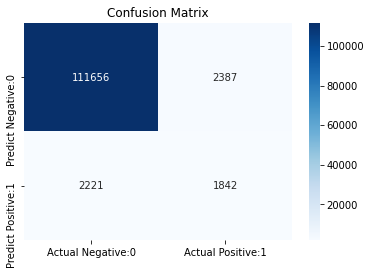

In [ ]:
# XGB with Early stopping

xgb = XGBClassifier(**best_params, tree_method='gpu_hist', 
                    reg_alpha=0.5
                    )

evaluation_set = [(test_X, test_y)]

xgb.fit(X, y, early_stopping_rounds=200, eval_metric="auc", eval_set=evaluation_set, verbose=100)

# Predict on test data
y_pred = xgb.predict(test_X)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                 index=['Predict Negative:0', 'Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues').set(title='Confusion Matrix')

In [ ]:
# Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(test_y, y_pred) 


0.42896101518046875

In [ ]:
FPR = (2387/(111656+2387))*100
TPR = (1847/(2221+1842))*100
print('True positive rate:', TPR),
print('False positive rate:', FPR)

True positive rate: 45.45902042825498
False positive rate: 2.0930701577475164


In [ ]:
# Create the predicted class
xgb = XGBClassifier(**best_params, tree_method='hist', reg_alpha=0.5)
y_pred = xgb.fit(X, y).predict_proba(test_X)[:,1]

In [ ]:
# AUC
roc_auc_score(test_y, y_pred)

0.8521982822957248

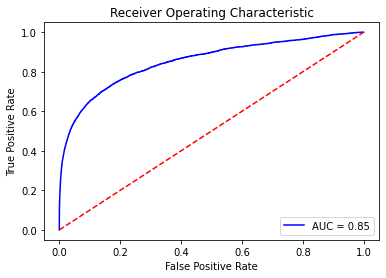

In [ ]:
# ROC CURVE
buildROC(test_y, y_pred)

##### Features importance

In [ ]:
# Weight importance
feature_importance = xgb.get_booster().get_score(importance_type= "weight")
feature_importance_weight = pd.DataFrame(list(feature_importance.items()))
feature_importance_weight.columns = ['Feature', 'Importance']

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(9, 5))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('XGBoost top 10 features')
    plt.tight_layout()

Feature       object
Importance     int64
dtype: object


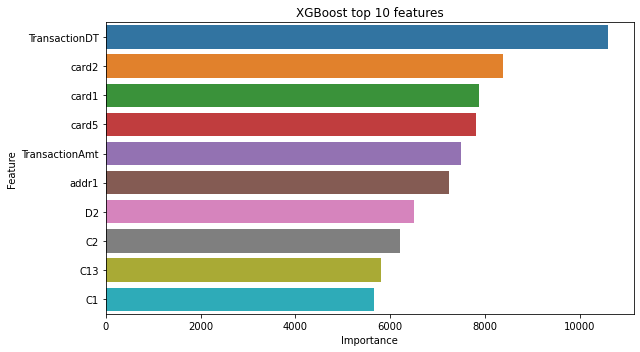

In [ ]:
display_importances(feature_importance_weight)